In [333]:
from pathlib import Path

from collections import Counter, defaultdict
import scipy

import pandas as pd
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# radCAD
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

pd.options.display.float_format = "{:.2f}".format

%matplotlib inline

In [343]:
def create_donut_charts(post_processing, donut_charts):
    num_bar_charts = len(donut_charts)
    fig, axs = plt.subplots(1, num_bar_charts, figsize=(7.5 * num_bar_charts, 6))

    for i, (labels, sizes, colors, title) in enumerate(donut_charts):
        values = [getattr(post_processing, attr).tail(1).values[0] for attr in sizes]
        total = sum(values)
        axs[i].pie(
            values,
            labels=labels,
            colors=colors,
            autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
            startangle=140,
            wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
            textprops=dict(color="black", fontsize=10),
        )
        axs[i].set_title(title)
        axs[i].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()
    return fig

In [375]:
def create_donut_charts2(dataframes, column_names):
    num_bar_charts = len(dataframes)
    fig, axs = plt.subplots(1, num_bar_charts, figsize=(7.5 * num_bar_charts, 6))

    for i, df in enumerate(dataframes):
        values = df[column_names[i]]
        labels = [*df.index]
        print(values)
        total = sum(values)
        axs[i].pie(
            values,
            labels=labels,
            # colors=colors,
            autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
            startangle=140,
            wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
            textprops=dict(color="black", fontsize=10),
        )
        axs[i].set_title(column_names[i])
        axs[i].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()
    return fig

In [335]:
outpath = Path('results/simul1')
outpath.mkdir(exist_ok=True)

In [336]:
from model.state_update_blocks import state_update_blocks
from model.sys_params import sys_params
from model.types.proposal_type import ProposalGeneration, ProposalSubType, ProposalType
from model.types.proposals import Proposal
from model.types.reaction_time import ModeledReactions
from model.types.scenario import Scenario
from model.utils.initialization import generate_initial_state
from model.utils.postprocessing import postprocessing

MONTE_CARLO_RUNS = 1
TIMESTEPS = 40

proposals = [
    Proposal(
        timestep=10,
        damage=100,
        proposal_type=ProposalType.Danger,
        sub_type=ProposalSubType.FundsStealing,
        proposer="0x98078db053902644191f93988341e31289e1c8fe",
        attack_targets={},
    ),
]

attackers = {"0x98078db053902644191f93988341e31289e1c8fe", "0xc329400492c6ff2438472d4651ad17389fcb843a"}

results = []
seeds = (1, 12, 123, 1234, 12345, 14121290)

for seed in seeds:
    state = generate_initial_state(
        Scenario.SingleAttack,
        ModeledReactions.Normal,
        ProposalType.Negative,
        ProposalSubType.NoEffect,
        ProposalGeneration.Random,
        initial_proposals=proposals,
        attackers=attackers,
        seed=seed,
    )
    
    model = Model(initial_state=state, params=sys_params, state_update_blocks=state_update_blocks)
    
    simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=MONTE_CARLO_RUNS)
    simulation.engine = Engine(backend=Backend.MULTIPROCESSING, processes=5, raise_exceptions=False, drop_substeps=True)
    
    result = simulation.run()
    results.append(result)
    # df = pd.DataFrame(result)
    # post_processing = postprocessing(df)
    # exceptions = simulation.exceptions

Counter({<ReactionTime.Slow: 3>: 884, <ReactionTime.NoReaction: 4>: 151, <ReactionTime.Normal: 1>: 140, <ReactionTime.Quick: 2>: 32})
[]
[Proposal(id=1, timestep=10, damage=100, proposer='0x98078db053902644191f93988341e31289e1c8fe', proposal_type=<ProposalType.Danger: 4>, sub_type=<ProposalSubType.FundsStealing: 2>, attack_targets={})]
{'0xc329400492c6ff2438472d4651ad17389fcb843a', '0x98078db053902644191f93988341e31289e1c8fe'}
identified non initialized proposal
submitting proposal with ID 1 at  2024-09-04 20:16:42.131923
2  attackers in the system that is going to steal  2211050398673270021455872  stETH and  892363936558242282224128  wstETH
stealing from honest actors  2.21105039867327e+24  stETH and  8.923639365582423e+23  wstETH
Proposal(id=1, timestep=10, damage=100, proposer='0x98078db053902644191f93988341e31289e1c8fe', proposal_type=<ProposalType.Danger: 4>, sub_type=<ProposalSubType.FundsStealing: 2>, attack_targets={})
Proposal ID 1 is going to be canceled.
last_canceled_propos

In [143]:
from specs.utils import ether_base
import re

def create_actors_df(simulation_results, out_dir=None):
    if out_dir == None:
        out_dir = Path('')
    out_filepath = out_dir.joinpath(Path('actors.csv'))

    value_dict = defaultdict(list)
    value_dict['reaction_delay'] = []
    for simulation_result in simulation_results:
        for row in simulation_result:
            seed = row['seed']
            timestep = row['timestep']
            for actor in row['actors']:
                for key, value in vars(actor).items():
                    if re.search('eth', key, flags=re.IGNORECASE):
                        value /= ether_base
                    value_dict[key].append(value)
                for key in value_dict:
                    if (key not in vars(actor)) and (key not in ('seed', 'timestep')):
                        value_dict[key].append(None)
                value_dict['seed'].append(seed)
                value_dict['timestep'].append(timestep)
    for key in value_dict:
        print(key, len(value_dict[key]))
    pd.DataFrame(value_dict).to_csv(out_filepath)
        

In [337]:
create_actors_df(results, outpath)

reaction_delay 296922
id 296922
actor_type 296922
address 296922
entity 296922
ldo_balance 296922
st_eth_balance 296922
initial_st_eth_balance 296922
st_eth_locked 296922
wstETH_balance 296922
initial_wstETH_balance 296922
wstETH_locked 296922
hypothetical_stETH_balance 296922
hypothetical_wstETH_balance 296922
last_locked_tx_timestamp 296922
starting_health 296922
health 296922
total_damage 296922
total_recovery 296922
governance_goal 296922
reaction_time 296922
governance_participation 296922
initial_health 296922
seed 296922
timestep 296922


In [338]:
actors_df = pd.read_csv(outpath.joinpath('actors.csv'))
actors_df.drop(columns=actors_df.columns[0], inplace=True)
actors_df['total_coins_balance'] = actors_df.wstETH_balance + actors_df.st_eth_balance
actors_df['total_coins_locked'] = actors_df.wstETH_locked + actors_df.st_eth_locked
actors_df['actor_locked'] = actors_df['total_coins_locked'] > 0
actors_df['actor_locked'] = actors_df['total_coins_locked'] > 0
total_actors = len(actors_df.id.unique())

sum_by_actors = actors_df.groupby(by=['seed', 'timestep']).sum(numeric_only=True).reset_index()
sum_by_actors.drop(columns=['id', 'last_locked_tx_timestamp'], inplace=True)
actors_df = actors_df.merge(sum_by_actors, on=['seed', 'timestep'], suffixes=('', '_sum'))

actors_df['total_coins_balance_relative'] = (actors_df['total_coins_balance'] / actors_df['total_coins_balance_sum']).replace(np.nan, 0)
actors_df['total_coins_locked_relative'] = (actors_df['total_coins_locked'] / actors_df['total_coins_balance_sum']).replace(np.nan, 0)
actors_df['actor_locked_relative'] = actors_df['actor_locked'] / total_actors
actors_df['health_relative'] = actors_df['health'] / actors_df['health_sum'][0]
actors_df['count'] = 1

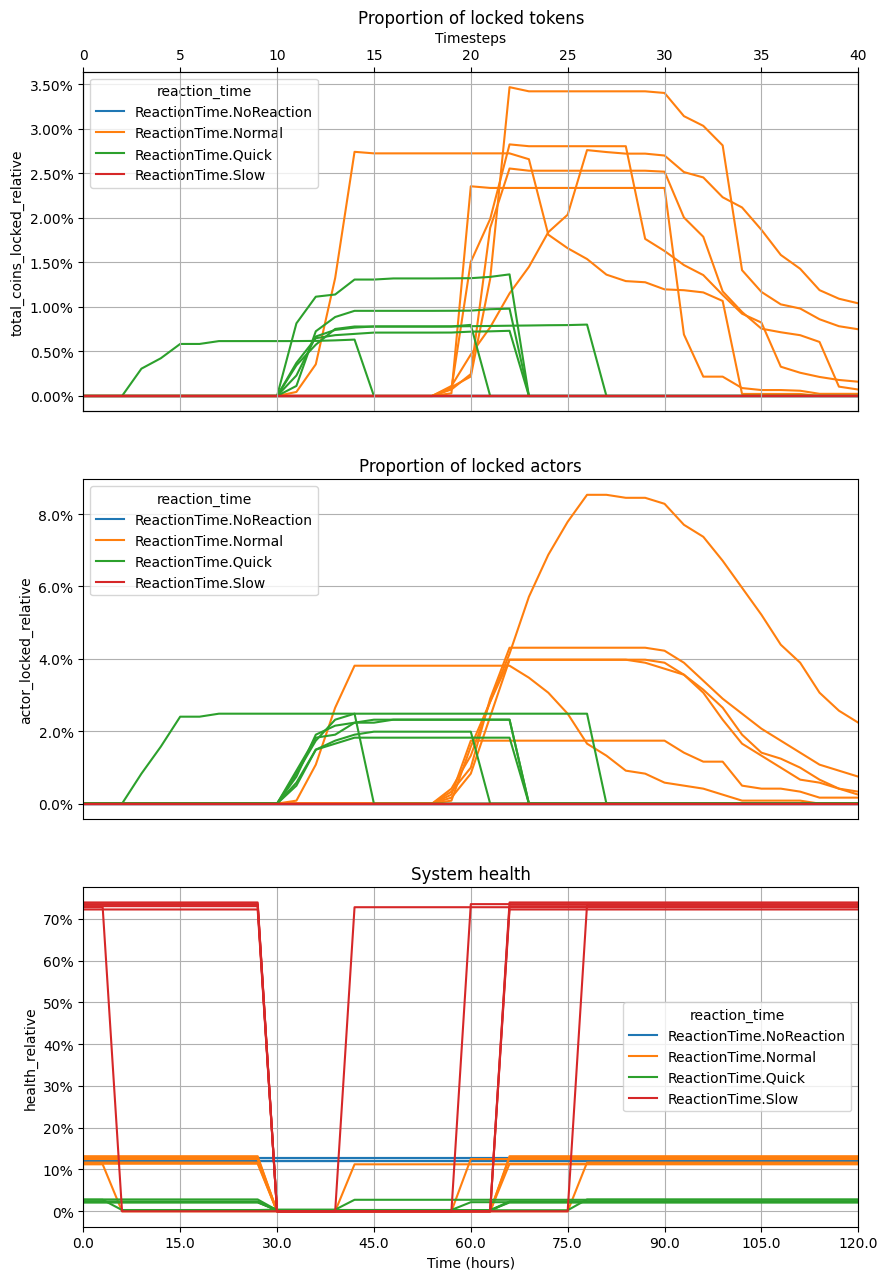

In [339]:
import seaborn as sns


ys = ('total_coins_locked_relative', 'actor_locked_relative', 'health_relative')
titles = ('Proportion of locked tokens', 'Proportion of locked actors', 'System health')

actors_df_summed_by_actors_rts = actors_df.groupby(by=['seed', 'timestep', 'reaction_time']).sum(numeric_only=True).reset_index()
actors_df_summed_by_actors = actors_df.groupby(by=['seed', 'timestep']).sum(numeric_only=True).reset_index()

basesize = 5
fig, axes = plt.subplots(figsize=(basesize * 2, basesize * len(ys)), nrows=len(ys), sharex=True)
for i, y in enumerate(ys):
    ax1 = axes[i]
    sns.lineplot(actors_df_summed_by_actors_rts, x='timestep', y=y, hue='reaction_time', ax=ax1, estimator=None, units='seed')
    # sns.lineplot(actors_df_summed_by_actors, x='timestep', y=y, ax=ax1, color='black', label='total', estimator=None, units='seed')
    ax1.set_xlabel('Time (hours)')
    # ax1.set_ylim(0, 0.15)
    ax1.set_xlim(0, 40)
    ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))

    if i == 0:
        ax2 = ax1.twiny()
        ax2.grid(True)
        ax2.set_xlabel('Timesteps')
        ax2.set_xticks(ax1.get_xticks())
        ax2.set_xlim(ax1.get_xlim())
    ax1.grid(True)
    if i != len(ys) - 1:
        ax1.get_xaxis().set_visible(False)
    
    title = titles[i]
    ax1.set_title(title)

plt.savefig(outpath.joinpath('Lock dynamics' + '.png'))
# sns.lineplot(actors_df, x='timestep', y='wstETH_locked', hue='reaction_time')

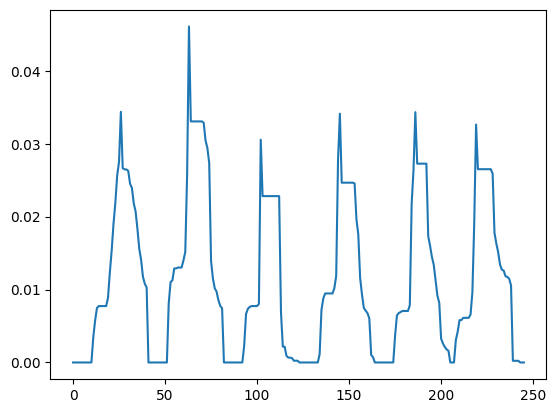

In [391]:
plt.plot(actors_df_summed_by_actors.total_coins_locked_sum / 8415184900.68)
# actors_df_summed_by_actors

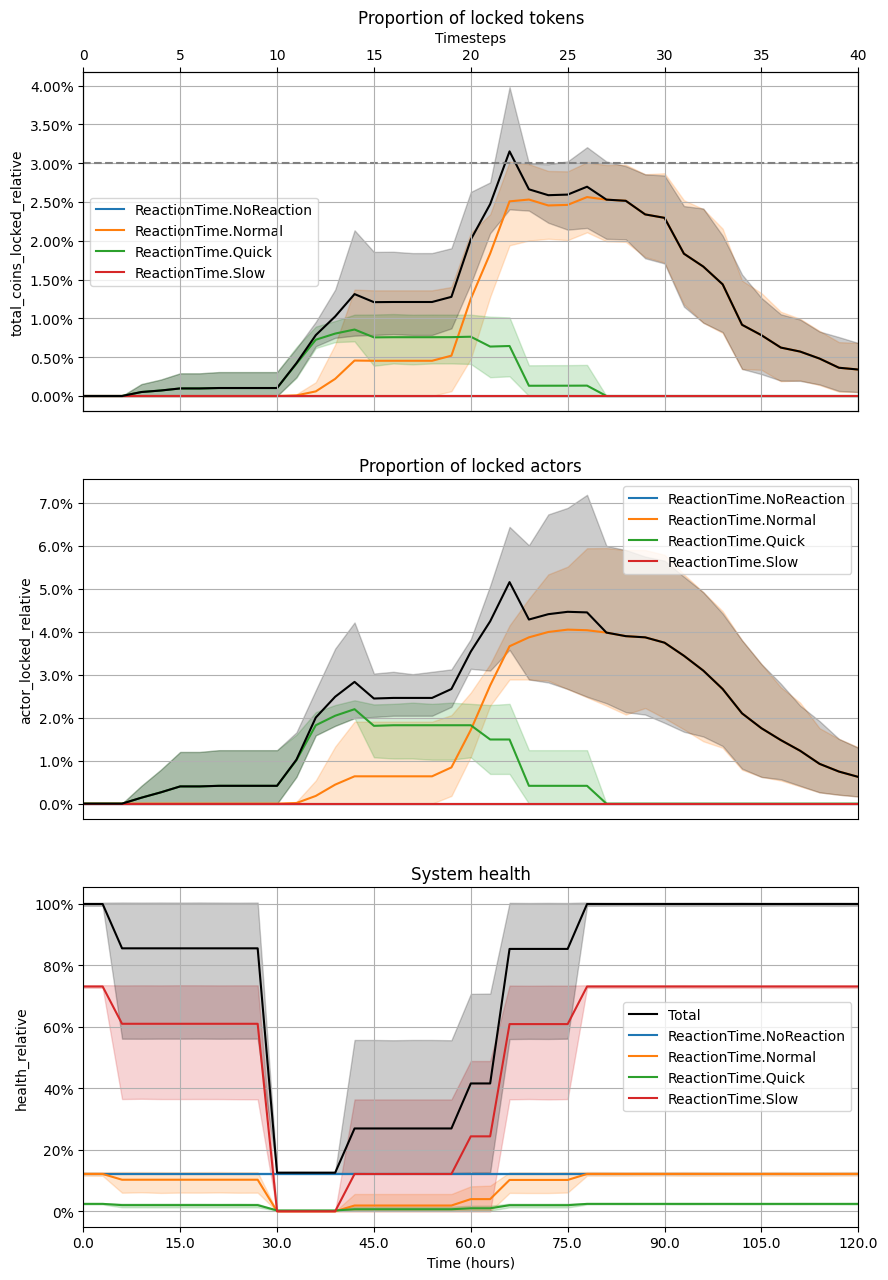

In [396]:
import seaborn as sns


ys = ('total_coins_locked_relative', 'actor_locked_relative', 'health_relative')
titles = ('Proportion of locked tokens', 'Proportion of locked actors', 'System health')

actors_df_summed_by_actors_rts = actors_df.groupby(by=['seed', 'timestep', 'reaction_time']).sum(numeric_only=True).reset_index()
actors_df_summed_by_actors = actors_df.groupby(by=['seed', 'timestep']).sum(numeric_only=True).reset_index()

basesize = 5
fig, axes = plt.subplots(figsize=(basesize * 2, basesize * len(ys)), nrows=len(ys), sharex=True)
for i, y in enumerate(ys):
    ax1 = axes[i]
    sns.lineplot(actors_df_summed_by_actors_rts, x='timestep', y=y, hue='reaction_time', ax=ax1)
    sns.lineplot(actors_df_summed_by_actors, x='timestep', y=y, ax=ax1, color='black')
    plt.plot([],[], color='black', label='Total')
    ax1.set_xlabel('Time (hours)')
    # ax1.set_ylim(0, 0.15)
    ax1.set_xlim(0, 40)
    ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))

    if y == 'total_coins_locked_relative':
        xlim = ax1.get_xlim()
        ax1.plot(xlim, [0.03, 0.03], linestyle='--', color='gray', label='Veto signalling threshold')
        ax1.set_xlim(xlim)

    if i == 0:
        ax2 = ax1.twiny()
        ax2.grid(True)
        ax2.set_xlabel('Timesteps')
        ax2.set_xticks(ax1.get_xticks())
        ax2.set_xlim(ax1.get_xlim())
    ax1.grid(True)
    if i != len(ys) - 1:
        ax1.get_xaxis().set_visible(False)
    
    title = titles[i]
    ax1.set_title(title)

plt.savefig(outpath.joinpath('Lock dynamics average' + '.png'))
# sns.lineplot(actors_df, x='timestep', y='wstETH_locked', hue='reaction_time')

Private     585
Contract    151
Custody      11
CEX           8
Name: entity, dtype: int64
entity
CEX         112984.04
Contract   3204682.82
Custody      70916.98
Private    3192183.50
Name: total_coins_balance, dtype: float64
is_private
Not Private   3388583.84
Private       3583400.34
Name: total_coins_balance, dtype: float64


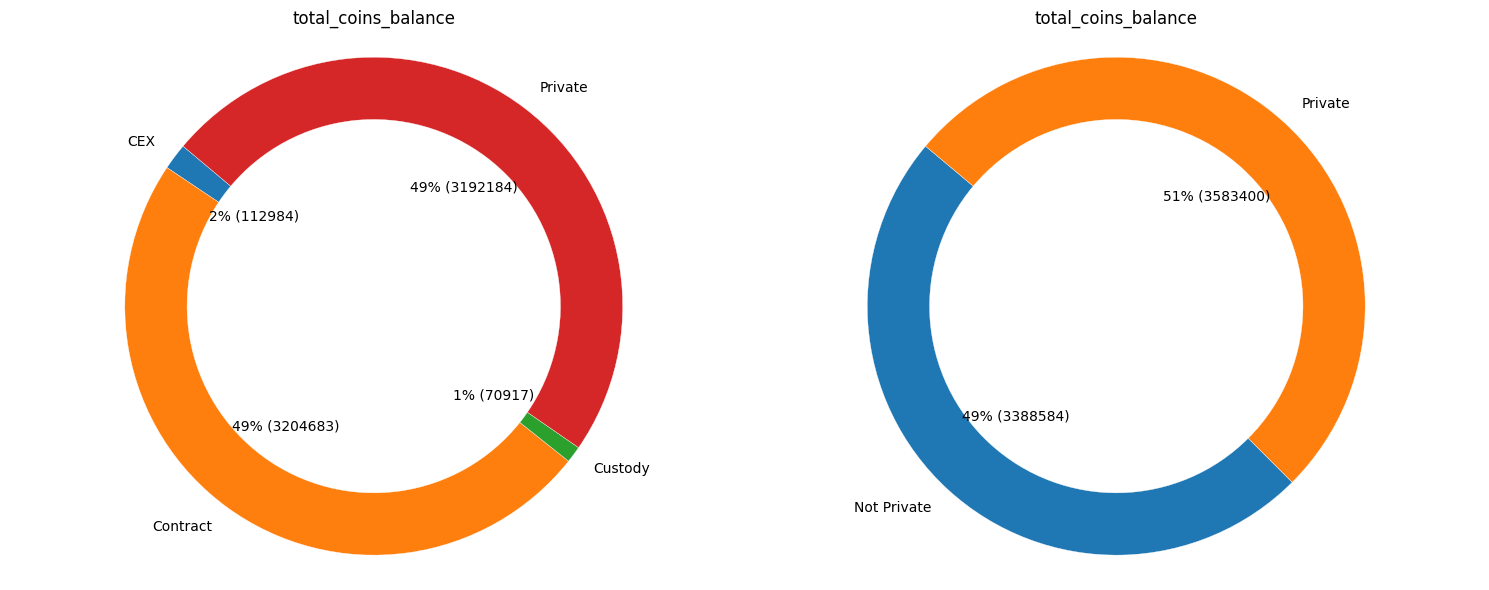

In [384]:
actors_start = actors_df[(actors_df['timestep'] == 0) & (actors_df['seed'] == 1)].copy()
actors_start['is_private'] = 'Private'
actors_start.loc[actors_start.entity.isin({'Contract', 'CEX', 'Custody'}), 'is_private'] = 'Not Private'
print(actors_start.entity.value_counts())

entity_summary = actors_start.groupby('entity').sum(numeric_only=True)
is_private_summary = actors_start.groupby('is_private').sum(numeric_only=True)

fig = create_donut_charts2([entity_summary, is_private_summary], ['total_coins_balance', 'total_coins_balance'])
fig.savefig(outpath.joinpath('Distribution of funds by wallet type' + '.png'))

Private     585
Contract    151
Custody      11
CEX           8
Name: entity, dtype: int64
entity
CEX           8
Contract    151
Custody      11
Private     585
Name: count, dtype: int64
is_private
Not Private     170
Private        1037
Name: count, dtype: int64


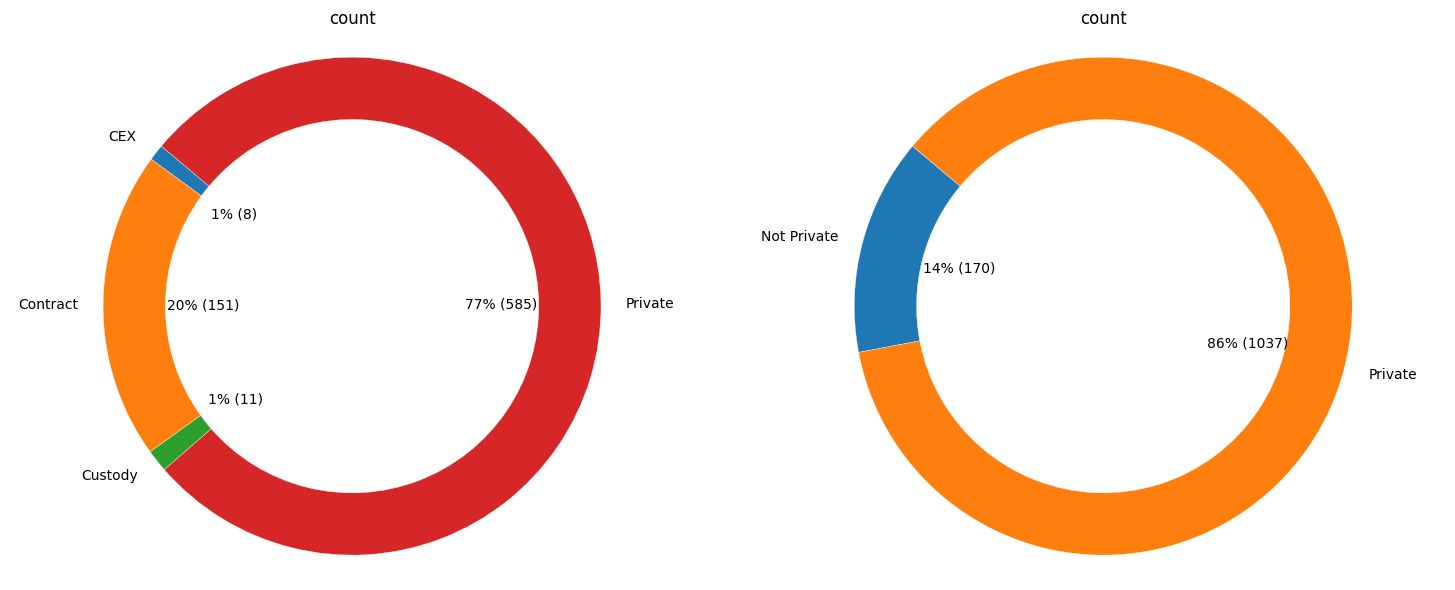

In [385]:
actors_start = actors_df[(actors_df['timestep'] == 0) & (actors_df['seed'] == 1)].copy()
actors_start['is_private'] = 'Private'
actors_start.loc[actors_start.entity.isin({'Contract', 'CEX', 'Custody'}), 'is_private'] = 'Not Private'
print(actors_start.entity.value_counts())

entity_summary = actors_start.groupby('entity').sum(numeric_only=True)
is_private_summary = actors_start.groupby('is_private').sum(numeric_only=True)

fig = create_donut_charts2([entity_summary, is_private_summary], ['count', 'count'])
fig.savefig(outpath.joinpath('Distribution of wallet types' + '.png'))

In [370]:
[*entity_summary.index]

['CEX', 'Contract', 'Custody', 'Private']

In [341]:
actors_distribution = (
    ["Attackers (Quick)", "Quick", "Normal", "Slow", "Non Reactive"],
    [
        "total_attackers",
        "total_quick_honest_actors_reaction_time",
        "total_normal_actors_reaction_time",
        "total_slow_actors_reaction_time",
        "total_non_reactive_actors_reaction_time"
    ],
    ["#D6292F", "#72FFFF", "#00D7FF", "#0096FF", "#101A36"],
    "Distribution of Actors reaction speed",
)

funds_distribution = (
    ["Attackers (Quick)", "Quick", "Normal", "Slow", "Non Reactive"],
    [
        "total_attackers_actors_funds",
        "total_quick_honest_actors_funds",
        "total_normal_actors_funds",
        "total_slow_actors_funds",
        "total_non_reactive_actors_funds"
    ],
    ["#D6292F", "#72FFFF", "#00D7FF", "#0096FF", "#101A36"],
    "Distribution of Funds of actors based on reaction speed",
)

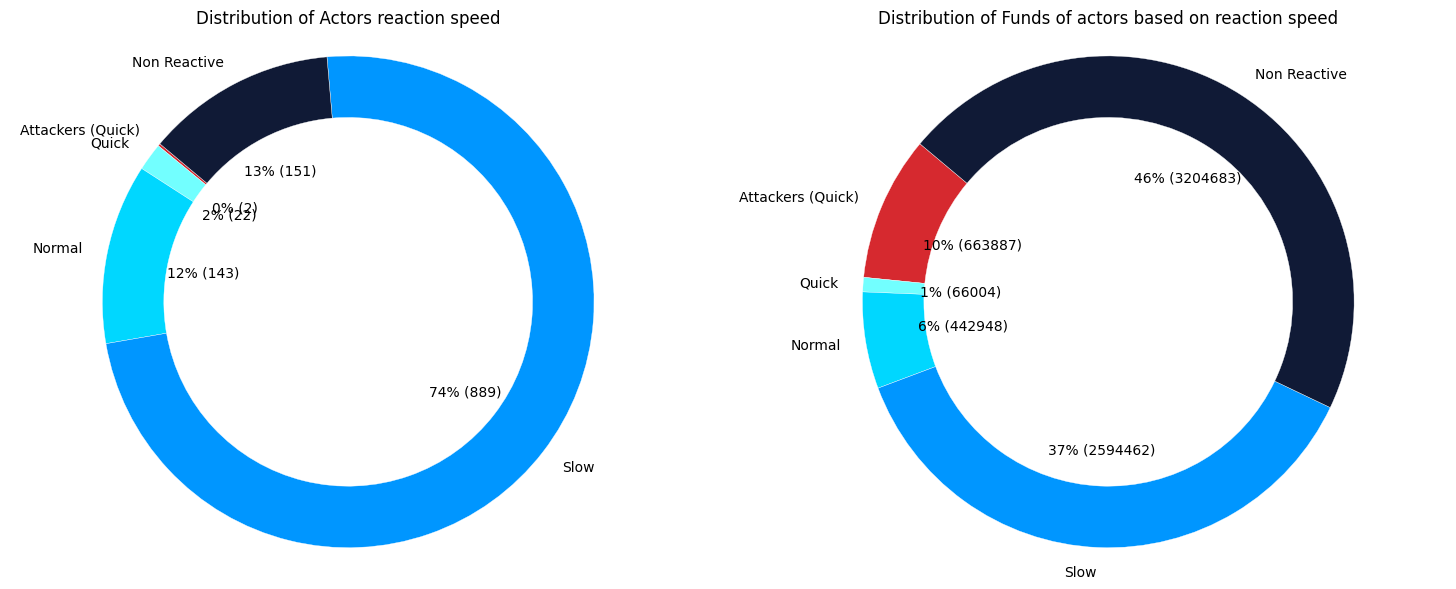

In [347]:
df = pd.DataFrame(results[3])
post_processing = postprocessing(df)
post_processing["total_quick_honest_actors_reaction_time"] = post_processing['total_quick_actors_reaction_time'] - post_processing['total_attackers']
post_processing['total_quick_honest_actors_funds'] = post_processing['total_quick_actors_funds'] - post_processing['total_attackers_actors_funds']
fig = create_donut_charts(post_processing, [actors_distribution, funds_distribution])
fig.savefig(outpath.joinpath('Reaction speed distribution' + '.png'))

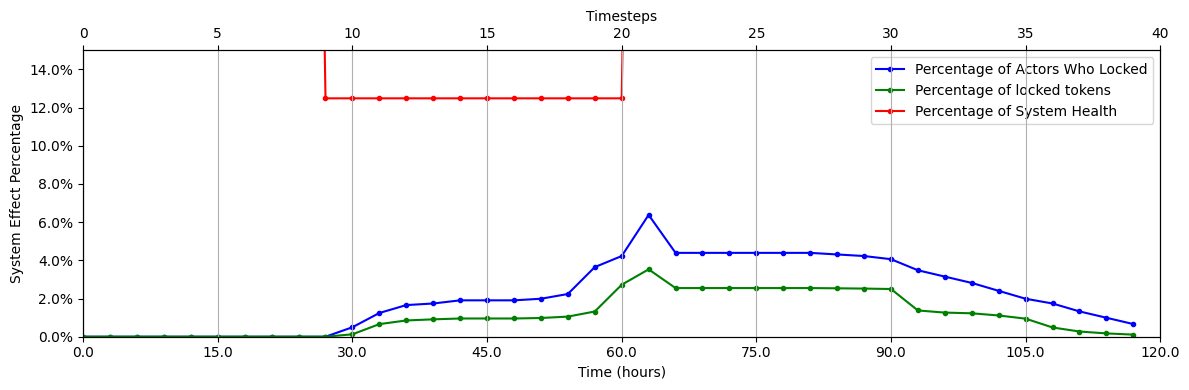

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

total_stETH_balance = post_processing["total_stETH_balance"]
total_stETH_locked = post_processing["total_stETH_locked"]
total_wstETH_balance = post_processing["total_wstETH_balance"]
total_wstETH_locked = post_processing["total_wstETH_locked"]
total_actors_damaged = post_processing["total_actors_damaged"]
total_actors_health = post_processing["total_actors_health"]
total_actors_recovery = post_processing["total_actors_recovery"]
rage_quit_support = post_processing["rage_quit_support"]
timesteps = range(len(total_stETH_balance))

total_locked_actors = df.actors.map(
    lambda actors: sum([1 for actor in actors if actor.st_eth_locked > 0 or actor.wstETH_locked > 0])
)[1:]
total_actors = len(df.actors[0])
locked_actors_normalized = total_locked_actors / total_actors

combined_balance = total_stETH_balance + total_wstETH_balance + total_stETH_locked + total_wstETH_locked
combined_locked = total_stETH_locked + total_wstETH_locked

percentage_locked = [
    (locked / balance) if balance != 0 else 0 for locked, balance in zip(combined_locked, combined_balance)
]

normalized_health = [
    health / (health + damage - recovery)
    for health, recovery, damage in zip(total_actors_health, total_actors_recovery, total_actors_damaged)
]

fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.plot(timesteps, locked_actors_normalized, color="blue", label="Percentage of Actors Who Locked", marker='o', markersize=3)
ax1.plot(timesteps, percentage_locked, color="green", label="Percentage of locked tokens", marker='o', markersize=3)
ax1.plot(timesteps, normalized_health, color="red", label="Percentage of System Health", marker='o', markersize=3)

ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("System Effect Percentage")
ax1.legend()
ax2 = ax1.twiny()
ax2.grid(True)
ax2.set_xlabel('Timesteps')
ax2.set_xticks(ax1.get_xticks())
ax1.set_ylim(0, 0.15)
ax1.set_xlim(0, 40)
ax2.set_xlim(ax1.get_xlim())
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))


plt.tight_layout()
plt.show()

In [44]:
ax1.get_xticks()

array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.])